# Assignment 2

## Task 1:
This task mirrors the structure of the California Housing analysis but applied to **Bitcoin (BTC/USD)** daily price data fetched from the Alpaca Markets API.

The primary objective is to conduct a comprehensive analysis through data preparation, model selection, training, and evaluation — predicting the **next-day closing price** of Bitcoin.

### 1. Introduction & Setup
In this section, we fetch daily **BTC/USD** OHLCV bars from the [Alpaca Markets Crypto API](https://docs.alpaca.markets/reference/cryptobars) and perform initial exploration of the dataset.

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame

# Fetch daily BTC/USD bars (no API key required for crypto data)
client = CryptoHistoricalDataClient()

request_params = CryptoBarsRequest(
    symbol_or_symbols=["BTC/USD"],
    timeframe=TimeFrame.Day,
    start=datetime(2022, 9, 1),
    end=datetime(2026, 1, 1)
)

btc_bars = client.get_crypto_bars(request_params)
raw_df = btc_bars.df.reset_index()
raw_df = raw_df[raw_df["symbol"] == "BTC/USD"].copy()

print(f"Shape: {raw_df.shape}")
print(f"Date range: {raw_df['timestamp'].min().date()} → {raw_df['timestamp'].max().date()}")
print(f"\nColumn dtypes:\n{raw_df.dtypes}")
raw_df.head()

Shape: (1219, 9)
Date range: 2022-09-01 → 2026-01-01

Column dtypes:
symbol                         str
timestamp      datetime64[us, UTC]
open                       float64
high                       float64
low                        float64
close                      float64
volume                     float64
trade_count                float64
vwap                       float64
dtype: object


,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,BTC/USD,2022-09-01 00:00:00+00:00,20051.81,20205.83,19564.86,20132.97,7529.674053,114052.0,19934.701556
1,BTC/USD,2022-09-02 00:00:00+00:00,20132.50,20444.00,19757.72,19954.16,7392.679014,98745.0,20095.899441
2,BTC/USD,2022-09-03 00:00:00+00:00,19950.63,20054.69,19658.04,19832.06,3077.135497,52729.0,19839.406563
3,BTC/USD,2022-09-04 00:00:00+00:00,19834.87,20030.89,19587.86,20002.38,3712.178165,60722.0,19813.537532
4,BTC/USD,2022-09-05 00:00:00+00:00,19998.77,20058.00,19635.96,19795.12,4817.489036,66396.0,19801.578592


### 2. Feature Analysis with Visualization

Explore features of interest in the BTC/USD dataset with two distinct plots that highlight price dynamics and trading activity over time.

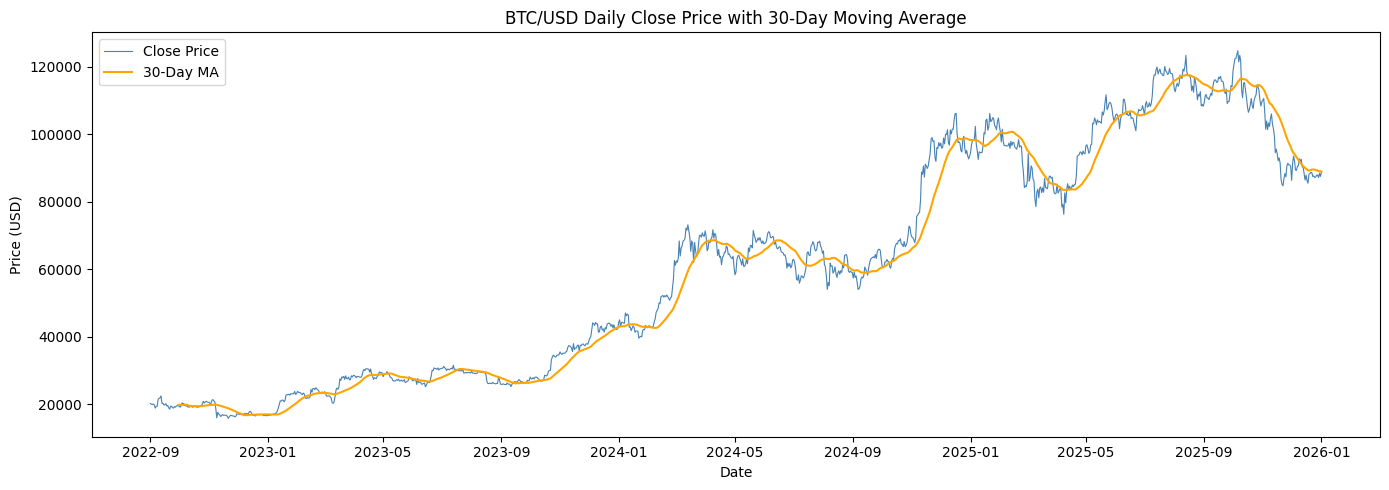

C:\Users\david\AppData\Local\Temp\ipykernel_15912\1302567652.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([normalised[col].dropna() for col in features_to_plot],


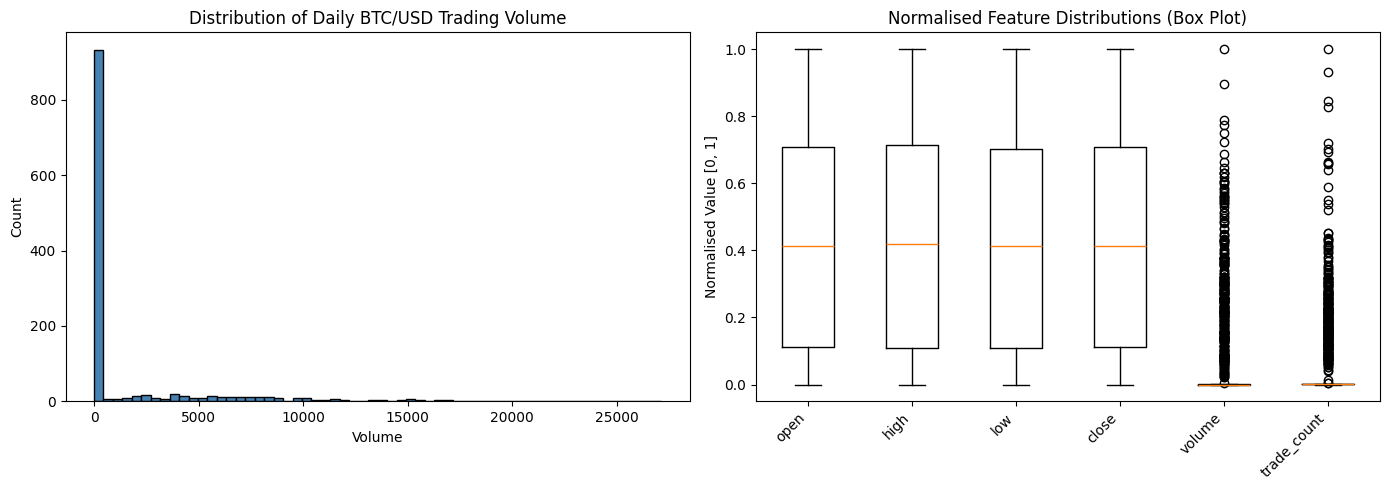

In [3]:

# Plot 1: BTC/USD closing price over time with a 30-day rolling average
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(raw_df['timestamp'], raw_df['close'], color='steelblue', linewidth=0.8, label='Close Price')
rolling_avg = raw_df['close'].rolling(window=30).mean()
ax.plot(raw_df['timestamp'], rolling_avg, color='orange', linewidth=1.5, label='30-Day MA')
ax.set_title('BTC/USD Daily Close Price with 30-Day Moving Average')
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')
ax.legend()
plt.tight_layout()
plt.show()

# Plot 2: Daily volume distribution (histogram) alongside a normalised box plot of all OHLCV features
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: histogram of daily trading volume
axes[0].hist(raw_df['volume'], bins=60, edgecolor='black', color='steelblue')
axes[0].set_xlabel('Volume')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Daily BTC/USD Trading Volume')

# Right: normalised box plot of OHLCV + trade_count features
features_to_plot = ['open', 'high', 'low', 'close', 'volume', 'trade_count']
normalised = raw_df[features_to_plot].copy()
normalised = (normalised - normalised.min()) / (normalised.max() - normalised.min())
axes[1].boxplot([normalised[col].dropna() for col in features_to_plot],
                labels=features_to_plot, vert=True)
axes[1].set_xticklabels(features_to_plot, rotation=45, ha='right')
axes[1].set_title('Normalised Feature Distributions (Box Plot)')
axes[1].set_ylabel('Normalised Value [0, 1]')

plt.tight_layout()
plt.show()


### 3. Data preparation

Data preparation is a critical step in the machine learning process. Apply data preparation steps to ensure the dataset is properly structured and ready for training.

In [6]:

# Prepare Bitcoin data for training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = raw_df.copy()

# Target: next-day closing price
df["target"] = df["close"].shift(-1)
df.dropna(inplace=True)

features = ["open", "high", "low", "volume", "trade_count"]

X = df[features]
y = df["target"]

print(f"Missing values:\n{X.isnull().sum()}")
print(f"\nDataset shape: {X.shape}")

# Time-series split – no shuffling to avoid look-ahead bias (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Scale features (required for KNN and Lasso; harmless for tree models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Convert back to DataFrames for convenience
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=features, index=X_test.index)

print(f"\nTrain size: {X_train_scaled.shape}, Test size: {X_test_scaled.shape}")
X_train_scaled.head()


Missing values:
open           0
high           0
low            0
volume         0
trade_count    0
dtype: int64

Dataset shape: (1218, 5)

Train size: (974, 5), Test size: (244, 5)


,open,high,low,volume,trade_count
0,-1.100753,-1.110388,-1.099892,1.299025,1.050161
1,-1.097710,-1.101586,-1.092474,1.266139,0.841101
2,-1.104569,-1.115973,-1.096308,0.230170,0.212623
3,-1.108934,-1.116852,-1.099007,0.382616,0.321790
4,-1.102753,-1.115851,-1.097157,0.647951,0.399284


### 4. Model selection

For ML models need to set hyperparameters before training, find the optimal combination of hyperparameters that will get the good model performance in this step.

In [13]:

# Model selection – GridSearchCV to find optimal hyperparameters (3-fold CV)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

cv = 3  # folds

# ── 1. KNN ───────────────────────────────────────────────────────────────────
knn_grid = GridSearchCV(
    KNeighborsRegressor(),
    param_grid={'n_neighbors': [3, 5, 7, 10, 15]},
    cv=cv, scoring='r2', n_jobs=-1
)
knn_grid.fit(X_train_scaled, y_train)
print(f"KNN       best params: {knn_grid.best_params_}  CV R²={knn_grid.best_score_:.4f}")

# ── 2. Lasso (Linear model) ───────────────────────────────────────────────────
lasso_grid = GridSearchCV(
    Lasso(max_iter=10000),
    param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1]},
    cv=cv, scoring='r2', n_jobs=-1
)
lasso_grid.fit(X_train_scaled, y_train)
print(f"Lasso     best params: {lasso_grid.best_params_}  CV R²={lasso_grid.best_score_:.4f}")

# ── 3. Decision Tree ──────────────────────────────────────────────────────────
dt_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid={'max_depth': [4, 6, 8, 10, None]},
    cv=cv, scoring='r2', n_jobs=-1
)
dt_grid.fit(X_train, y_train)   # trees don't need scaling
print(f"DecTree   best params: {dt_grid.best_params_}  CV R²={dt_grid.best_score_:.4f}")

# ── 4. Random Forest ──────────────────────────────────────────────────────────
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid={'n_estimators': [50, 100, 200], 'max_depth': [5, 9, 12, None]},
    cv=cv, scoring='r2', n_jobs=-1
)
rf_grid.fit(X_train, y_train)
print(f"RF        best params: {rf_grid.best_params_}  CV R²={rf_grid.best_score_:.4f}")

# ── 5. Gradient Boosting ──────────────────────────────────────────────────────
gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid={
        'n_estimators': [100, 200],
        'max_depth':    [3, 5],
        'min_samples_split': [2, 10]
    },
    cv=cv, scoring='r2', n_jobs=-1
)
gb_grid.fit(X_train, y_train)
print(f"GradBoost best params: {gb_grid.best_params_}  CV R²={gb_grid.best_score_:.4f}")

# ── 6. AdaBoost ───────────────────────────────────────────────────────────────
ada_grid = GridSearchCV(
    AdaBoostRegressor(random_state=42),
    param_grid={'n_estimators': range(50, 350, 50)},
    cv=cv, scoring='r2', n_jobs=-1
)
ada_grid.fit(X_train, y_train)
print(f"AdaBoost  best params: {ada_grid.best_params_}  CV R²={ada_grid.best_score_:.4f}")


KNN       best params: {'n_neighbors': 3}  CV R²=0.2035
Lasso     best params: {'alpha': 1}  CV R²=0.9807
DecTree   best params: {'max_depth': 6}  CV R²=0.1575
RF        best params: {'max_depth': None, 'n_estimators': 200}  CV R²=0.1912
GradBoost best params: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}  CV R²=0.2991
AdaBoost  best params: {'n_estimators': 50}  CV R²=-0.0919


### 5. Model training

Train KNN, linear model, and tree-based models.

In [ ]:

# Training – extract best estimators from GridSearchCV and record predictions
# KNN and Lasso use scaled features; tree models use raw features

models = {
    'KNN':            (knn_grid.best_estimator_,   X_train_scaled, X_test_scaled),
    'Lasso':          (lasso_grid.best_estimator_,  X_train_scaled, X_test_scaled),
    'Decision Tree':  (dt_grid.best_estimator_,     X_train,        X_test),
    'Random Forest':  (rf_grid.best_estimator_,     X_train,        X_test),
    'Gradient Boost': (gb_grid.best_estimator_,     X_train,        X_test),
    'AdaBoost':       (ada_grid.best_estimator_,    X_train,        X_test),
}

predictions = {}   # store test predictions for evaluation

for name, (model, X_tr, X_te) in models.items():
    y_pred = model.predict(X_te)
    predictions[name] = y_pred
    print(f"{name:20s} – training done, {len(y_pred)} test predictions generated")


KNN                  – training done, 244 test predictions generated
Lasso                – training done, 244 test predictions generated
Decision Tree        – training done, 244 test predictions generated
Random Forest        – training done, 244 test predictions generated
Gradient Boost       – training done, 244 test predictions generated
AdaBoost             – training done, 244 test predictions generated


### 6. Evaluation

Compare the results of all ML models, and find the one with the best performance.

Model Comparison (sorted by R²):
                     RMSE      R²
Lasso           2218.4124  0.9532
KNN             8655.1461  0.2884
Gradient Boost  8909.0305  0.2460
Decision Tree   9003.5447  0.2299
Random Forest   9568.7971  0.1302
AdaBoost       10334.2943 -0.0145


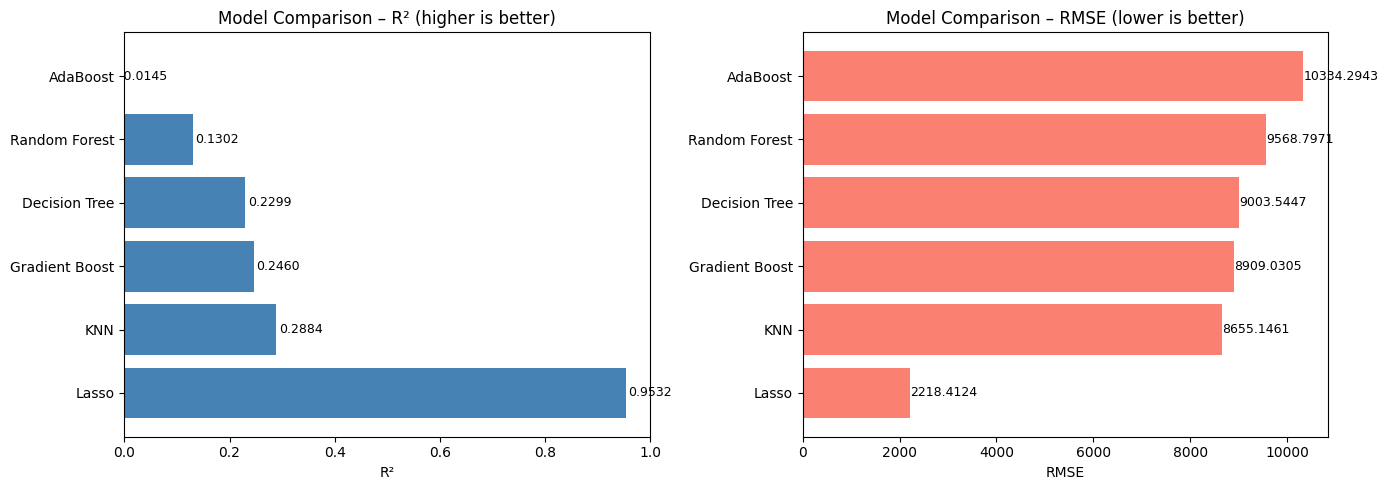


Best model: Lasso  (R²=0.9532, RMSE=2218.4124)


In [9]:

# Evaluation – compare all models using RMSE and R²
from sklearn.metrics import mean_squared_error, r2_score

results = {}
for name, y_pred in predictions.items():
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R²': r2}

results_df = pd.DataFrame(results).T.sort_values('R²', ascending=False)
print("Model Comparison (sorted by R²):")
print(results_df.to_string(float_format='{:.4f}'.format))

# ---- bar chart comparison ----
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
model_names = results_df.index

# R²
bars = axes[0].barh(model_names, results_df['R²'], color='steelblue')
axes[0].set_xlabel('R²')
axes[0].set_title('Model Comparison – R² (higher is better)')
axes[0].set_xlim(0, 1)
for bar, val in zip(bars, results_df['R²']):
    axes[0].text(val + 0.005, bar.get_y() + bar.get_height()/2,
                 f'{val:.4f}', va='center', fontsize=9)

# RMSE
bars = axes[1].barh(model_names, results_df['RMSE'], color='salmon')
axes[1].set_xlabel('RMSE')
axes[1].set_title('Model Comparison – RMSE (lower is better)')
for bar, val in zip(bars, results_df['RMSE']):
    axes[1].text(val + 0.001, bar.get_y() + bar.get_height()/2,
                 f'{val:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

best_model_name = results_df.index[0]
print(f"\nBest model: {best_model_name}  (R²={results_df.loc[best_model_name,'R²']:.4f}, "
      f"RMSE={results_df.loc[best_model_name,'RMSE']:.4f})")


### 7. Important features
Find top 3 important features by using LASSO or random forest.

LASSO – feature importances (|coefficient|):
high          20853.963426
low           10424.242891
open           4799.790169
volume          103.750228
trade_count       0.376458

Top 3 features (LASSO): ['high', 'low', 'open']

Random Forest – feature importances:
high          0.474833
low           0.280737
open          0.243262
volume        0.000594
trade_count   0.000574

Top 3 features (Random Forest): ['high', 'low', 'open']


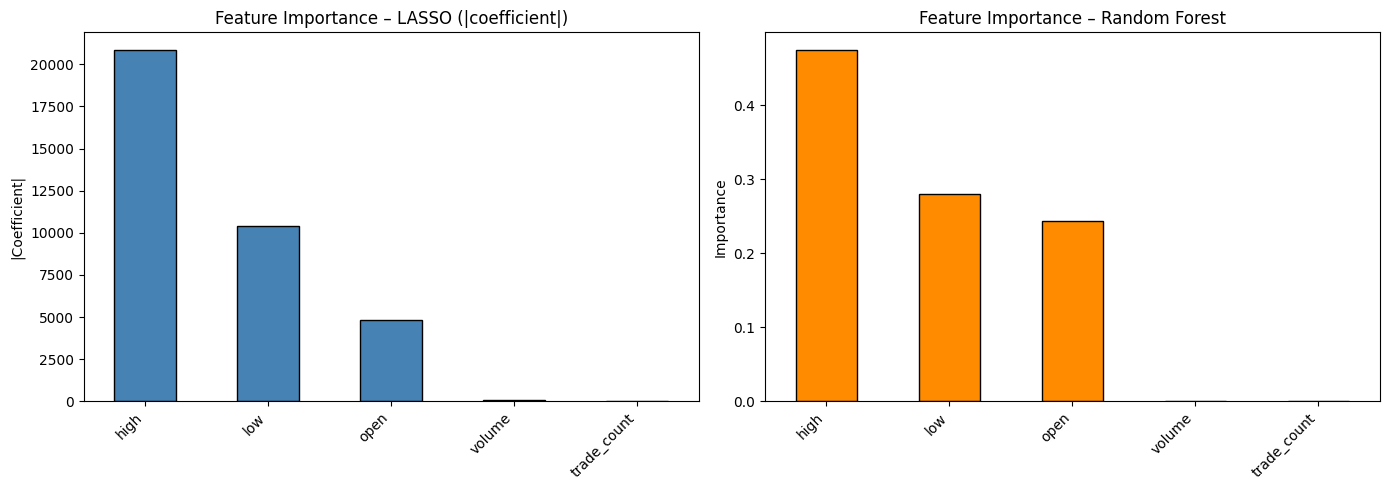


── Summary ───────────────────────────────────────────────
Top 3 by LASSO          : ['high', 'low', 'open']
Top 3 by Random Forest  : ['high', 'low', 'open']


In [10]:

# Feature selection – top 3 important features via LASSO and Random Forest

# ── Method 1: LASSO coefficients ────────────────────────────────────────────
lasso_best = lasso_grid.best_estimator_
lasso_importance = pd.Series(
    np.abs(lasso_best.coef_), index=X.columns
).sort_values(ascending=False)

print("LASSO – feature importances (|coefficient|):")
print(lasso_importance.to_string(float_format='{:.6f}'.format))
print(f"\nTop 3 features (LASSO): {list(lasso_importance.head(3).index)}")

# ── Method 2: Random Forest feature importances ──────────────────────────────
rf_best = rf_grid.best_estimator_
rf_importance = pd.Series(
    rf_best.feature_importances_, index=X.columns
).sort_values(ascending=False)

print("\nRandom Forest – feature importances:")
print(rf_importance.to_string(float_format='{:.6f}'.format))
print(f"\nTop 3 features (Random Forest): {list(rf_importance.head(3).index)}")

# ── Side-by-side bar chart ───────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

lasso_importance.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Feature Importance – LASSO (|coefficient|)')
axes[0].set_ylabel('|Coefficient|')
axes[0].set_xticklabels(lasso_importance.index, rotation=45, ha='right')

rf_importance.plot(kind='bar', ax=axes[1], color='darkorange', edgecolor='black')
axes[1].set_title('Feature Importance – Random Forest')
axes[1].set_ylabel('Importance')
axes[1].set_xticklabels(rf_importance.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# ── Final summary ─────────────────────────────────────────────────────────────
top3_lasso = list(lasso_importance.head(3).index)
top3_rf    = list(rf_importance.head(3).index)
print("\n── Summary ───────────────────────────────────────────────")
print(f"Top 3 by LASSO          : {top3_lasso}")
print(f"Top 3 by Random Forest  : {top3_rf}")


## Task 2: Decision Tree Calculation

#### Given the dataset, please provide the detailed calculations to build a CART to predict `EnjoySport?` with the depth of 2.

| Index | Sky | Humidity | Water | Forecast | EnjoySport? | 
|----------|----------|----------|----------|----------|----------|
| 1| Sunny| Normal| Warm| Same| Yes|
| 2| Sunny| High| Warm| Same| Yes|
| 3| Rainy| High| Warm| Change| No|
| 4| Sunny| High| Cold| Change| Yes|
| 5| Sunny| Normal| Warm| Same| No|

- Base libraries like `numpy` can be used for math calculation, but `sklearn` is not allowed in this task.
- Submit your final answer as a PDF document. You may present your work in either handwritten form, typed, or in any other format that clearly demonstrates your full calculations and reasoning.